In [5]:
import os

import numpy as np
from astropy.io import fits
import importlib

import statmorph
from statmorph.utils.image_diagnostics import make_figure
from scripts import segmentation_map, circular_segmentation_map, zoom_in, plot_light, display_img
%matplotlib inline

In [6]:
def print_src_morphs(source_morphs, index):
    print('BASIC MEASUREMENTS (NON-PARAMETRIC)')
    print('xc_centroid =', source_morphs[index].xc_centroid)
    print('yc_centroid =', source_morphs[index].yc_centroid)
    print('ellipticity_centroid =', source_morphs[index].ellipticity_centroid)
    print('elongation_centroid =', source_morphs[index].elongation_centroid)
    print('orientation_centroid =', source_morphs[index].orientation_centroid)
    print('xc_asymmetry =', source_morphs[index].xc_asymmetry)
    print('yc_asymmetry =', source_morphs[index].yc_asymmetry)
    print('ellipticity_asymmetry =', source_morphs[index].ellipticity_asymmetry)
    print('elongation_asymmetry =', source_morphs[index].elongation_asymmetry)
    print('orientation_asymmetry =', source_morphs[index].orientation_asymmetry)
    print('rpetro_circ =', source_morphs[index].rpetro_circ)
    print('rpetro_ellip =', source_morphs[index].rpetro_ellip)
    print('rhalf_circ =', source_morphs[index].rhalf_circ)
    print('rhalf_ellip =', source_morphs[index].rhalf_ellip)
    print('r20 =', source_morphs[index].r20)
    print('r80 =', source_morphs[index].r80)
    print('Gini =', source_morphs[index].gini)
    print('M20 =', source_morphs[index].m20)
    print('F(G, M20) =', source_morphs[index].gini_m20_bulge)
    print('S(G, M20) =', source_morphs[index].gini_m20_merger)
    print('sn_per_pixel =', source_morphs[index].sn_per_pixel)
    print('C =', source_morphs[index].concentration)
    print('A =', source_morphs[index].asymmetry)
    print('S =', source_morphs[index].smoothness)
    print()
    print('SERSIC MODEL')
    print('sersic_amplitude =', source_morphs[index].sersic_amplitude)
    print('sersic_rhalf =', source_morphs[index].sersic_rhalf)
    print('sersic_n =', source_morphs[index].sersic_n)
    print('sersic_xc =', source_morphs[index].sersic_xc)
    print('sersic_yc =', source_morphs[index].sersic_yc)
    print('sersic_ellip =', source_morphs[index].sersic_ellip)
    print('sersic_theta =', source_morphs[index].sersic_theta)
    print('sersic_chi2_dof =', source_morphs[index].sersic_chi2_dof)
    print()
    print('OTHER')
    print('sky_mean =', source_morphs[index].sky_mean)
    print('sky_median =', source_morphs[index].sky_median)
    print('sky_sigma =', source_morphs[index].sky_sigma)
    print('flag =', source_morphs[index].flag)
    print('flag_sersic =', source_morphs[index].flag_sersic)
    return

In [7]:
def create_morph_df(source_morphs, name=None, save=False):
    
    sources = []
    for src in source_morphs:
        sources.append({
            'xc_centroid': src.xc_centroid,
            'yc_centroid': src.yc_centroid,
            'ellipticity_centroid': src.ellipticity_centroid,
            'elongation_centroid': src.elongation_centroid,
            'orientation_centroid': src.orientation_centroid,
            'xc_asymmetry': src.xc_asymmetry,
            'yc_asymmetry': src.yc_asymmetry,
            'ellipticity_asymmetry': src.ellipticity_asymmetry,
            'elongation_asymmetry': src.elongation_asymmetry,
            'orientation_asymmetry': src.orientation_asymmetry,
            'rpetro_circ': src.rpetro_circ,
            'rpetro_ellip': src.rpetro_ellip,
            'rhalf_circ': src.rhalf_circ,
            'rhalf_ellip': src.rhalf_ellip,
            'r20': src.r20,
            'r80': src.r80,
            'Gini': src.gini,
            'M20': src.m20,
            'F(G, M20)': src.gini_m20_bulge,
            'S(G, M20)': src.gini_m20_merger,
            'sn_per_pixel': src.sn_per_pixel,
            'C': src.concentration,
            'A': src.asymmetry,
            'S': src.smoothness,
            'sersic_amplitude': src.sersic_amplitude,
            'sersic_rhalf': src.sersic_rhalf,
            'sersic_n': src.sersic_n,
            'sersic_xc': src.sersic_xc,
            'sersic_yc': src.sersic_yc,
            'sersic_ellip': src.sersic_ellip,
            'sersic_theta': src.sersic_theta,
            'sersic_chi2_dof': src.sersic_chi2_dof,
            'sky_mean': src.sky_mean,
            'sky_median': src.sky_median,
            'sky_sigma': src.sky_sigma,
            'flag': src.flag,
            'flag_sersic': src.flag_sersic,
        })
    sources = pd.DataFrame(sources)
    if save:
        sources.to_csv('a383_source_morphs.csv')
        # sources.to_csv(name)
    return sources

In [8]:
data_dir = 'cluster_data/'
drz_file = os.path.join(data_dir, 'hlsp_clash_hst_acs-wfc3ir_a383_total_v1_drz.fits')
whz_file = os.path.join(data_dir, 'hlsp_clash_hst_acs-wfc3ir_a383_total_v1_whz.fits')
hdulist = fits.open(drz_file)
# hdulist.info()
# hdulist[0].header

In [9]:
drz = hdulist[0].data
full_segmap = segmentation_map(drz, nsigma=10.)

In [10]:
full_source_morphs = statmorph.source_morphology(image=drz,
                                                 segmap=full_segmap,
                                                 gain=2.25)

/Users/kabelo/.conda/envs/cluster_morph/lib/python3.13/site-packages/statmorph/statmorph.py:691: RuntimeWarning: invalid value encountered in sqrt
  local_std = np.sqrt(local_mean2 - local_mean**2)
/Users/kabelo/.conda/envs/cluster_morph/lib/python3.13/site-packages/statmorph/statmorph.py:691: RuntimeWarning: invalid value encountered in sqrt
  local_std = np.sqrt(local_mean2 - local_mean**2)


In [11]:
def func(src):
    return src.r50      # sort on half-light radius to get BCG

full_source_morphs.sort(reverse=True, key=func)
bcg = full_source_morphs[1]

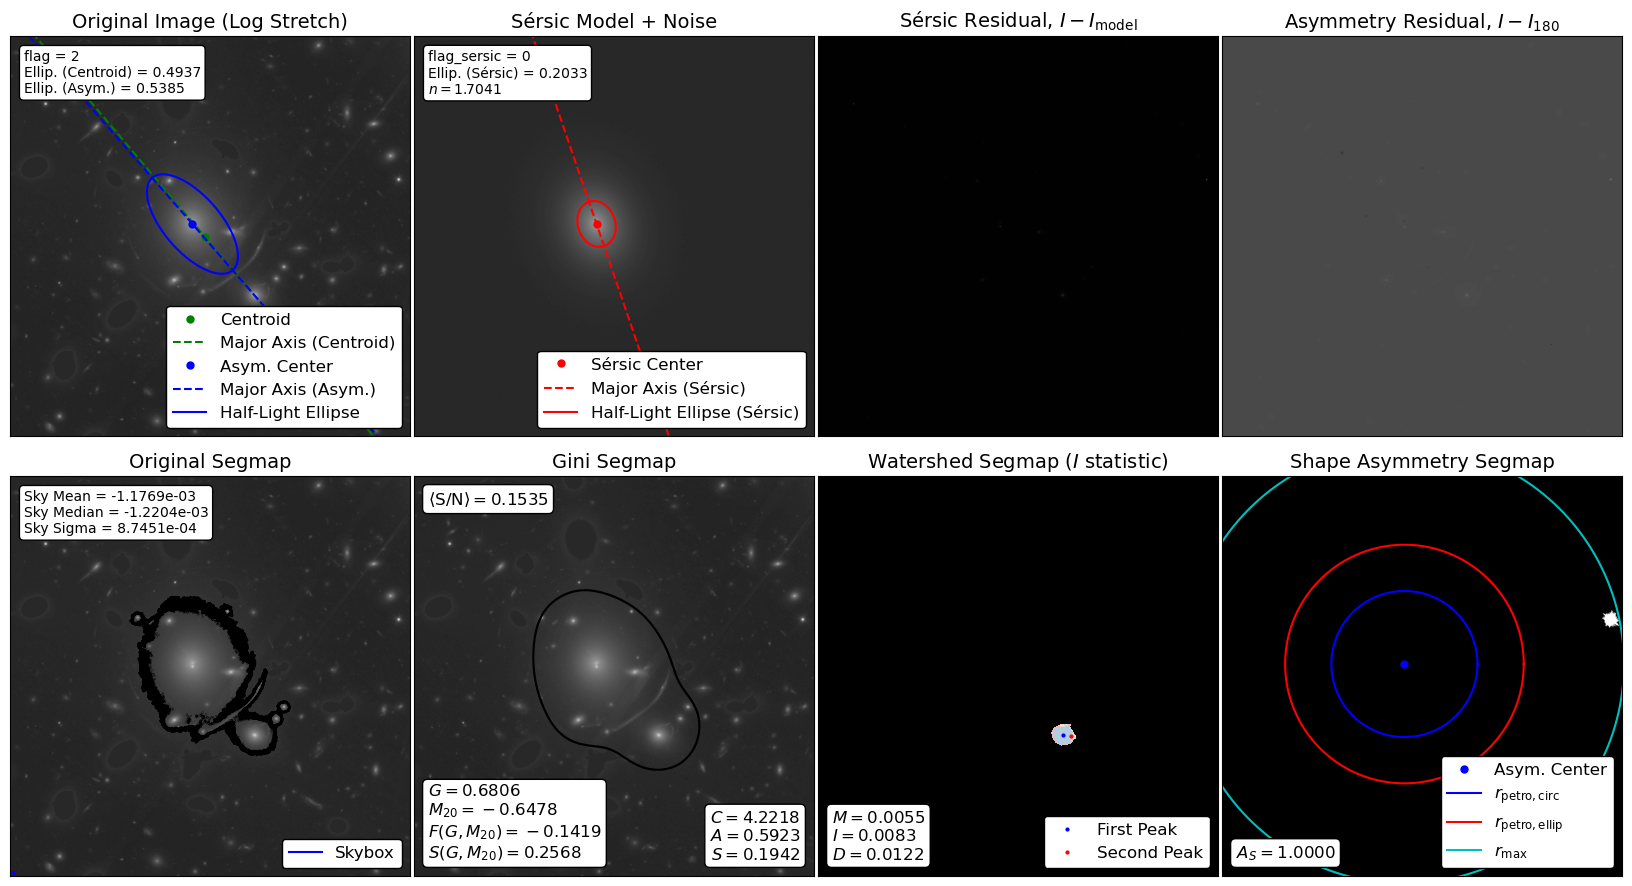

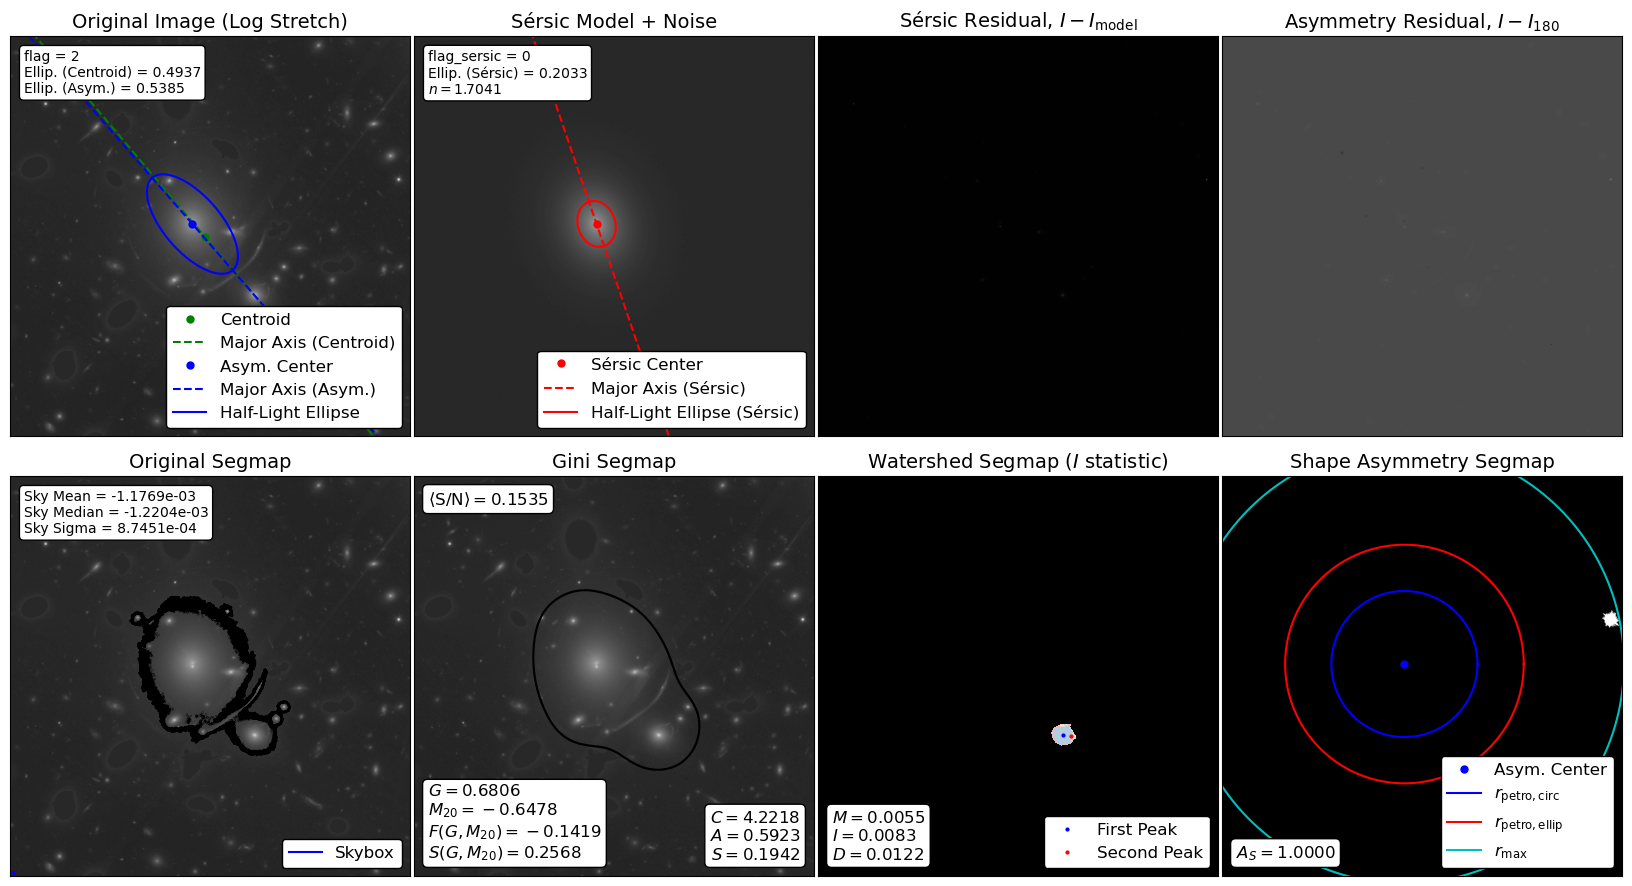

In [8]:
make_figure(bcg)

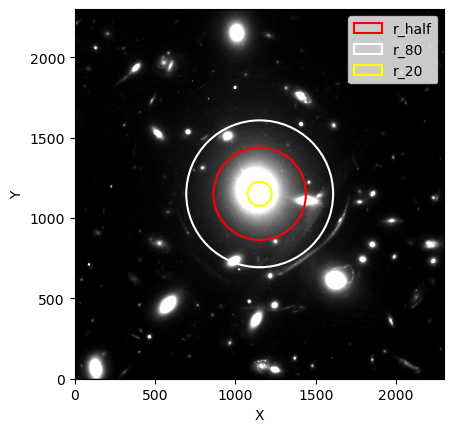

In [16]:
zoomed_region, zoom_size = zoom_in(bcg, drz)
plot_light(bcg, zoomed_region, zoom_size)

In [17]:
center = (bcg.xc_centroid, bcg.yc_centroid)
mask = circular_segmentation_map(drz, center,
                                 radius=bcg.r50*5)

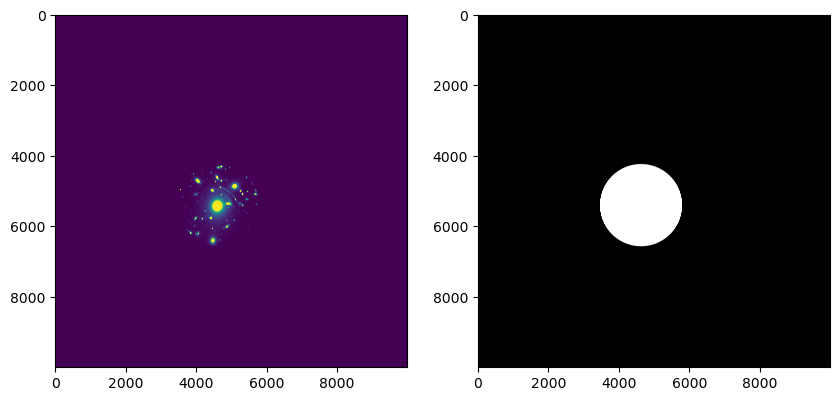

In [19]:
masked_img = np.zeros_like(drz)
masked_img[mask] = drz[mask]
display_img(masked_img, mask)

In [ ]:
full_morph_df = create_morph_df(full_source_morphs)
full_s_corr_matrix = full_morph_df.corr(method='spearman')

In [ ]:
mask = np.triu(np.ones_like(full_s_corr_matrix, dtype=np.bool))
plt.figure(figsize=(25, 25))
fhm = sns.heatmap(full_s_corr_matrix, mask=mask, cmap='coolwarm', square=True)
plt.title('Full Spearman Correlation Matrix Heatmap')
plt.show()

In [140]:
selection = []
good_cols = []
for i, x in enumerate(full_s_corr_matrix):
    lst = full_s_corr_matrix[x][np.abs(full_s_corr_matrix[x]) > 0.8]
    good_cols.append(x)
    for c in lst.index:
        if c in good_cols:
            continue
        else:
            selection.append((x, c))

In [ ]:
for i, row in enumerate(selection):
    if i in range(30,40):
        rho = full_s_corr_matrix[row[0]][row[1]]
        df = full_morph_df[[row[0], row[1]]]
        joint = sns.jointplot(data=df, x=row[0], y=row[1], height=4)
        joint.figure.suptitle("r = " + str(rho))
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

In [23]:
sm_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(10000, 10000))

In [25]:
sm_mask = mask.astype(int)
r50_12 = statmorph.source_morphology(drz,
                                     segmap=sm_mask,
                                     gain=2.25)

KeyboardInterrupt: 

In [ ]:
for source in r50_12:
    print(source.flag)

In [ ]:
make_figure(r50_12[0])

In [211]:
morph_df = create_morph_df(r50_12)
s_corr_matrix = morph_df.corr(method='spearman')

In [ ]:
mask = np.triu(np.ones_like(s_corr_matrix, dtype=np.bool))
plt.figure(figsize=(25, 25))
fhm = sns.heatmap(s_corr_matrix, mask=mask, cmap='coolwarm', square=True)
plt.title('Spearman Correlation Matrix Heatmap')
plt.show()